# Alex Deleon MATH328

In this analysis we will attempt to predict whether or not a patient will have a stroke based on a number of characteristics. This dataset is interesting to me because two of my family members had strokes in my youth. Other family members almost had one. Because of this I seeking to know from a statistical perspective, what are some predictors of strokes?

I found this dataset on kaggle https://www.kaggle.com/fedesoriano/stroke-prediction-dataset. The data source is "confidential". This dataset contains information on patients who had (or did not have) a stroke. Patient information includes gender, body mass index, average glucose level, residence type, if the patient is a smoker, and so on.

#### What is the structure or shape of the data?

The stroke dataset is rectangular and in csv format. There is a mixture of quantitative and qualitiative dataset.

Quantitative columns: age (discrete), average glucose level (continuous), and body mass index (continuous).
Qualitative columns: gender (nominal), presence of hypertension (binary), presence of heart disease (binary), marriage status (binary), type of work (nominal), type of residence (nominal), smoker status (binary), recorded stroke (binary)

#### What is the granularity of the data?

Each row represents a patient, i.e., a person. 

####  What is the scope or completeness of the data?

The data satisfies our question(s) of interest. We can identify the variables that best explain or predict a stoke.

#### What is the temporality of the data, or how does the data relate to time?

It does not specify when the data was collected.

#### What is the faithfulness of the data, or how well does the data capture reality?

The data seems legitamate at first sight. What is troublesome is the lack of documentation and methodology provided for the dataset. How exactly was this dataset collected and by who? This question is vital.


In [21]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
%matplotlib inline

pd.set_option('display.max_columns', None)

In [22]:
from pathlib import Path
import os

BASE_DIR = Path(os.path.abspath('')).resolve()
STROKE_PATH= BASE_DIR.joinpath('STROKE_DATA.csv')
stroke_df=pd.read_csv(STROKE_PATH)

# Missing Values

### We see that there are some missing values in the column bmi and smoking_status. For some patients, smoking status is "Unknown". Let's treat these .

In [23]:
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Let's check if we should impute "Unknown" smoking status values as "No" for children. We see that children are defined as any patient under the age of 16.

In [24]:
max_age=stroke_df.loc[stroke_df['work_type']=='children','age'].max()
print ("The max age for a patient to be considered a child in this dataset is",max_age)

The max age for a patient to be considered a child in this dataset is 16.0


### There may be some mistakes where work type for children under 14 is something other than "children". Under the Fair Labor Standards Act ([FLSA](https://www.dol.gov/agencies/whd/flsa)), the minimum age for employment is 14. Let's verify that the work type of patients under 14 is "children". There are 15 patients under 14 with a  work type that is not "children". Let substitue these values.

In [25]:
def child_work(row):
    if (row['age']<14 and row['work_type']!='children'):
        row['work_type']='children'
    return row

stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children         630
Private           10
Never_worked       3
Self-employed      2
Name: work_type, dtype: int64

### Non-children values have been changed to "children".

In [26]:
stroke_df = stroke_df.apply(child_work,axis=1) 
stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children    645
Name: work_type, dtype: int64

### The assumption can be made that all children in this dataset are non-smokers. However, this depends on how smoking is defined. If this dataset considers children who experience secondhand smoke as patients who smoke, then this assumption would be wrong. From the cross tab below, we see that it is possible that this dataset considers secondhand smoke. There are 15 children who have either smoked or formely smoked.

In [27]:
pd.crosstab(stroke_df.work_type,stroke_df.smoking_status)

smoking_status,Unknown,formerly smoked,never smoked,smokes
work_type,,,,
Govt_job,122,133,282,120
Never_worked,6,0,13,0
Private,636,531,1206,542
Self-employed,155,207,331,124
children,625,14,60,3


In [28]:
stroke_df=stroke_df.drop(columns='smoking_status')

In [29]:
def bmi_class(row):
    if row<18.5:
        return 1
    elif row<25 and row>=18.5:
        return 2
    elif row <30 and row>=25:
        return 3
    elif row <35 and row>=30:
        return 4
    elif row <40 and row>=35:
        return 5
    elif row>=40:
        return 6   
    
def obese_class(row):
    if row <35 and row>=30:
        return 1
    elif row <40 and row>=35:
        return 2
    elif row>=40:
        return 3
    else:
        return 0
def diabetes_class(row):
    if row>200:
        return 1
    else:
        return 0
# If your BMI is less than 18.5, it falls within the underweight range.
# If your BMI is 18.5 to <25, it falls within the normal.
# If your BMI is 25.0 to <30, it falls within the overweight range.
# If your BMI is 30.0 or higher, it falls within the obesity range.
# Class 1: BMI of 30 to < 35
# Class 2: BMI of 35 to < 40
# Class 3: BMI of 40 or higher. Class 3 obesity is sometimes categorized as “extreme” or “severe” obesity.

### We will drop all rows that have smoker labeled as "Unknown"

In [30]:
stroke_df['diabetic']=stroke_df.loc[:,'avg_glucose_level'].apply(diabetes_class)

In [31]:
nulls=stroke_df[stroke_df['bmi'].isna()].copy()
stroke_df=stroke_df[~stroke_df['bmi'].isna()].copy()
stroke_df.loc[:,'bmi_group']=stroke_df.loc[:,'bmi'].apply(bmi_class)
stroke_df_temp=stroke_df.copy()

In [32]:
nulls

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,diabetic
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,1,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,1,0
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,1,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,1,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,0,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,0,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,0,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,0,0


In [33]:
stroke_df_temp['stroke'].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

In [34]:
stroke_df_temp.loc[:,'bmi_group']=stroke_df.loc[:,'bmi'].apply(bmi_class)
stroke_df_temp.loc[:,'obese_class']= stroke_df.loc[:,'bmi'].apply(obese_class)
stroke_df_temp['stroke'] = stroke_df_temp['stroke'].apply(lambda x: 'Yes' if int(x)==1 else 'No')

In [35]:
stroke_df_temp

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,diabetic,bmi_group,obese_class
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,Yes,1,5,2
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,Yes,0,4,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,Yes,0,4,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,Yes,0,2,0
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,Yes,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,No,0,2,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,No,0,6,3
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,No,0,4,1
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,No,0,3,0


In [36]:
stroke_df_temp['stroke'].unique()

array(['Yes', 'No'], dtype=object)

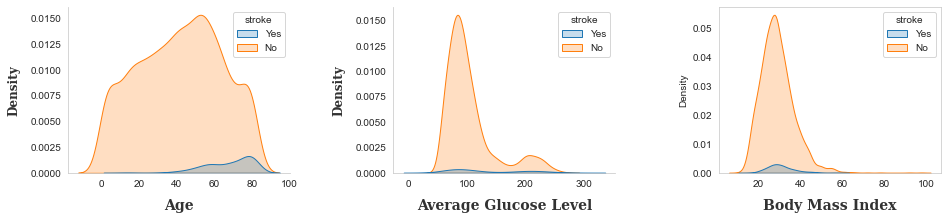

In [37]:
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1,3, figsize = (14,4))
sns.set_style("white")
axes[0].set_xlabel("Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[1].set_xlabel("Average Glucose Level", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(stroke_df_temp['age'] ,shade=True,hue=stroke_df_temp['stroke'],ax=axes[0],palette= sns.color_palette("tab10")[0:2])
sns.kdeplot(stroke_df_temp['avg_glucose_level'],shade=True,hue=stroke_df_temp['stroke'],ax=axes[1],palette= sns.color_palette("tab10")[0:2])
sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2],palette= sns.color_palette("tab10")[0:2])

for i in range(0,2):
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=4.0)

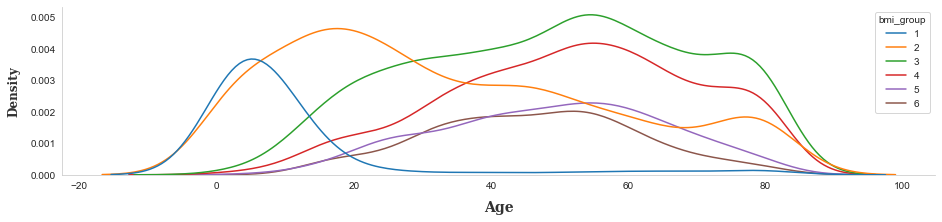

In [38]:
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1,1, figsize = (14,4))
sns.set_style("white")
axes.set_xlabel("Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[1].set_xlabel("Average Glucose Level", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(stroke_df_temp['age'] ,hue=stroke_df_temp['bmi_group'],ax=axes,palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(stroke_df_temp['avg_glucose_level'],hue=stroke_df_temp['bmi_group'],ax=axes[1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])


axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=4.0)

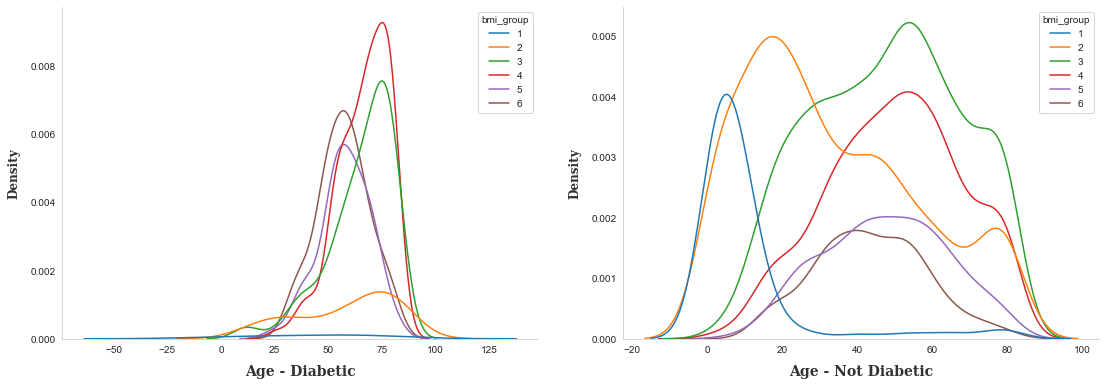

In [39]:
diabetic=stroke_df_temp[stroke_df_temp['diabetic']==1].copy()
normal=stroke_df_temp[stroke_df_temp['diabetic']==0].copy()
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1,2, figsize = (16,6))
sns.set_style("white")
axes[0].set_xlabel("Age - Diabetic", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10 ) 
#axes[0,1].set_xlabel("Diabetic - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[1,0].set_xlabel("Normal - Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[1].set_xlabel("Age - Not Diabetic", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(diabetic['age'] ,hue=diabetic['bmi_group'],ax=axes[0],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(diabetic['avg_glucose_level'],hue=diabetic['bmi_group'],ax=axes[0,1],palette= sns.color_palette("tab10")[0:6])
sns.kdeplot(normal['age'] ,hue=normal['bmi_group'],ax=axes[1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(normal['avg_glucose_level'],hue=normal['bmi_group'],ax=axes[1,1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])

for i in [0,1]:
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=3.0)

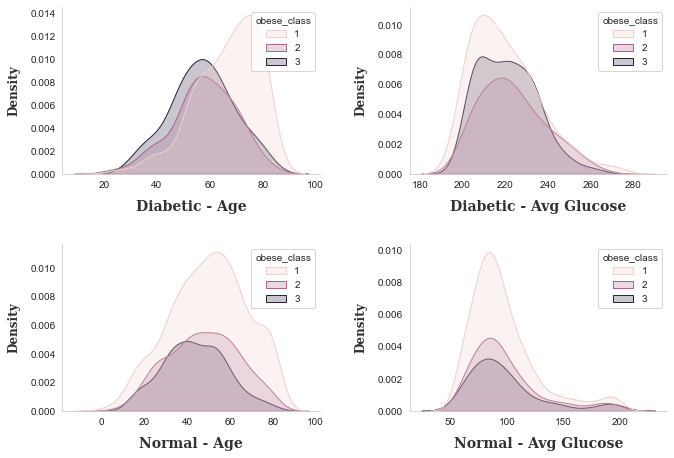

In [40]:
diabetic=stroke_df_temp[(stroke_df_temp['diabetic']==1)&(stroke_df_temp['obese_class']!=0)].copy()
normal=stroke_df_temp[(stroke_df_temp['diabetic']==0)&(stroke_df_temp['obese_class']!=0)].copy()
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(2,2, figsize = (10,7))
sns.set_style("white")
axes[0,0].set_xlabel("Diabetic - Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[0,1].set_xlabel("Diabetic - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
axes[1,0].set_xlabel("Normal - Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[1,1].set_xlabel("Normal - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(diabetic['age'],shade = True ,hue=diabetic['obese_class'],ax=axes[0,0])
sns.kdeplot(diabetic['avg_glucose_level'],shade = True ,hue=diabetic['obese_class'],ax=axes[0,1])
sns.kdeplot(normal['age'],shade = True ,hue=normal['obese_class'],ax=axes[1,0])
sns.kdeplot(normal['avg_glucose_level'],shade = True ,hue=normal['obese_class'],ax=axes[1,1])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])

for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    axes[i,j].spines['right'].set_visible(False)
    axes[i,j].spines['top'].set_visible(False)
    axes[i,j].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=3.0)

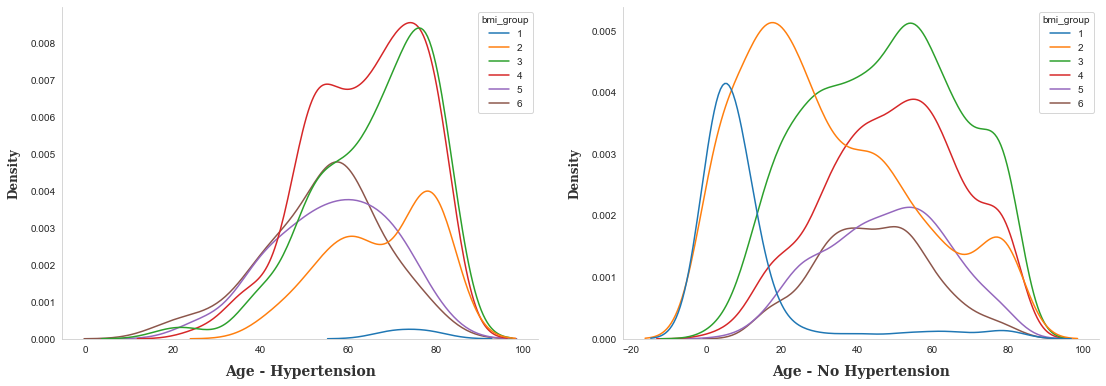

In [41]:
hypertension=stroke_df_temp[stroke_df_temp['hypertension']==1].copy()
no_hypertension=stroke_df_temp[stroke_df_temp['hypertension']==0].copy()
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1,2, figsize = (16,6))
sns.set_style("white")
axes[0].set_xlabel("Age - Hypertension", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[0].set_xlabel("Hypertension - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
axes[1].set_xlabel("Age - No Hypertension", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[1].set_xlabel("No Hypertension - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(hypertension['age'] ,hue=hypertension['bmi_group'],ax=axes[0],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(hypertension['avg_glucose_level'] ,hue=hypertension['bmi_group'],ax=axes[0,1],palette= sns.color_palette("tab10")[0:6])
sns.kdeplot(no_hypertension['age'],hue=no_hypertension['bmi_group'],ax=axes[1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(no_hypertension['avg_glucose_level'] ,hue=no_hypertension['bmi_group'],ax=axes[1,1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])

for i in [0,1]:
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=3.0)

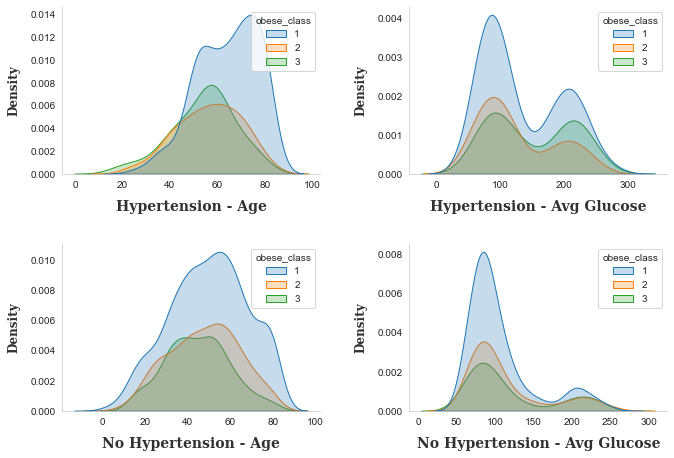

In [42]:
hypertension=stroke_df_temp[(stroke_df_temp['hypertension']==1)&(stroke_df_temp['obese_class']!=0)].copy()
no_hypertension=stroke_df_temp[(stroke_df_temp['hypertension']==0)&(stroke_df_temp['obese_class']!=0)].copy()
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(2,2, figsize = (10,7))
sns.set_style("white")
axes[0,0].set_xlabel("Hypertension - Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[0,1].set_xlabel("Hypertension - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
axes[1,0].set_xlabel("No Hypertension - Age", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
axes[1,1].set_xlabel("No Hypertension - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(hypertension['age'],shade = True ,hue=hypertension['obese_class'],ax=axes[0,0],palette= sns.color_palette("tab10")[0:3])
sns.kdeplot(hypertension['avg_glucose_level'],shade = True ,hue=hypertension['obese_class'],ax=axes[0,1],palette= sns.color_palette("tab10")[0:3])
sns.kdeplot(no_hypertension['age'],shade = True ,hue=no_hypertension['obese_class'],ax=axes[1,0],palette= sns.color_palette("tab10")[0:3])
sns.kdeplot(no_hypertension['avg_glucose_level'],shade = True ,hue=no_hypertension['obese_class'],ax=axes[1,1],palette= sns.color_palette("tab10")[0:3])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])

for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    axes[i,j].spines['right'].set_visible(False)
    axes[i,j].spines['top'].set_visible(False)
    axes[i,j].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=3.0)

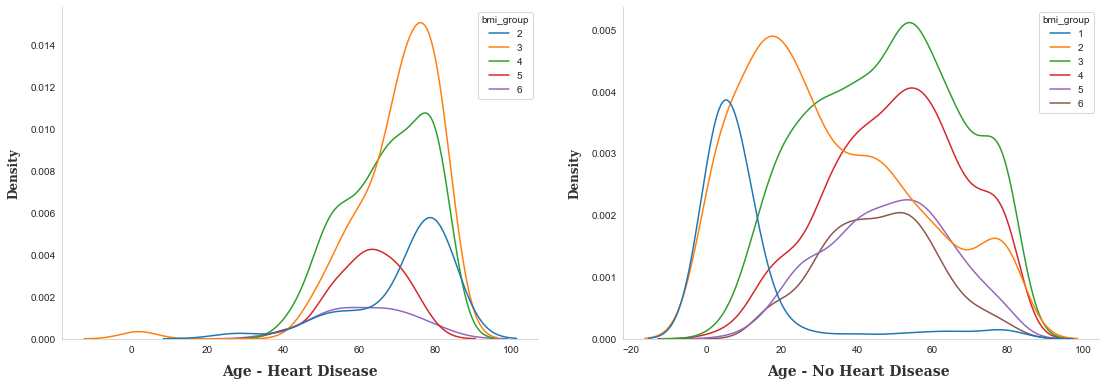

In [43]:
heart_disease=stroke_df_temp[(stroke_df_temp['heart_disease']==1)].copy()
no_heart_disease=stroke_df_temp[stroke_df_temp['heart_disease']==0].copy()
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1,2, figsize = (16,6))
sns.set_style("white")
axes[0].set_xlabel("Age - Heart Disease", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[0].set_xlabel("Heart Disease - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
axes[1].set_xlabel("Age - No Heart Disease ", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  
#axes[1].set_xlabel("No Heart Disease - Avg Glucose", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 
#axes[2].set_xlabel("Body Mass Index", fontsize=14, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10) 

sns.kdeplot(heart_disease['age'],hue=heart_disease['bmi_group'],ax=axes[0],palette= sns.color_palette("tab10")[0:5])
#sns.kdeplot(heart_disease['avg_glucose_level'],hue=heart_disease['bmi_group'],ax=axes[0,1],palette= sns.color_palette("tab10")[0:5])
sns.kdeplot(no_heart_disease['age'],hue=no_heart_disease['bmi_group'],ax=axes[1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(no_heart_disease['avg_glucose_level'],hue=no_heart_disease['bmi_group'],ax=axes[1,1],palette= sns.color_palette("tab10")[0:6])
#sns.kdeplot(stroke_df_temp['bmi'],shade = True ,hue=stroke_df_temp['stroke'],ax=axes[2])

for i in [1,0]:
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel("Density", fontsize=12, fontweight='bold', fontfamily='serif', color="#323232",labelpad=10)  

f.tight_layout(pad=3.0)

### We will drop the row where gender is labeled as "Other"

In [44]:
stroke_df['gender'].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

In [45]:
stroke_df['gender'] = stroke_df['gender'].replace('Other', np.nan)
stroke_df=stroke_df.dropna()
stroke_df['gender'].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [46]:
stroke_df['bmi_group']=stroke_df['bmi_group'].replace({6:4,5:4,4:3})
str_only = stroke_df[stroke_df['stroke'] == 1]
no_str_only = stroke_df[stroke_df['stroke'] ==0]
ticks= {'gender':['Female','Male'],
        'ever_married':['Not Married','Married'],
        'heart_disease':['No Heart\nDisease','Heart\nDisease'],
        'hypertension':['No History','History'],
        'Residence_type':['Rural','Urban'],
        'smoking_status':['Previous \n Smoker','Never \n Smoker','Smoker'],
        'work_type':['Govt. \n Employee','Never Worked','Private','Self-Employed','Child'],
        'bmi_group':['Underweight','Normal','Overweight-Obese 1','Obese 2-3']
       }

xlabels={'gender':'Gender',
         'ever_married':'Marriage Status',
         'heart_disease':'Heart Disease',
         'hypertension':'Hypertension',
         'Residence_type':'Residence Type',
         'smoking_status':'Smoking Status',
         'work_type':'Work Type',
         'bmi_group':'BMI Groups'}

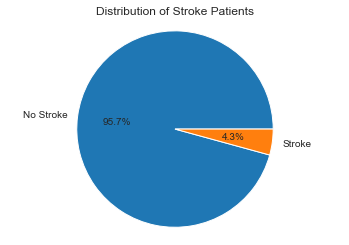

In [47]:
stroke_percent=stroke_df['stroke'].value_counts()/stroke_df['stroke'].shape[0]
stroke_percent.to_list()
import seaborn as sns

plt.pie(stroke_percent.to_list(),labels=['No Stroke','Stroke'],autopct='%1.1f%%')
plt.title('Distribution of Stroke Patients')
plt.axis('equal')
plt.show()

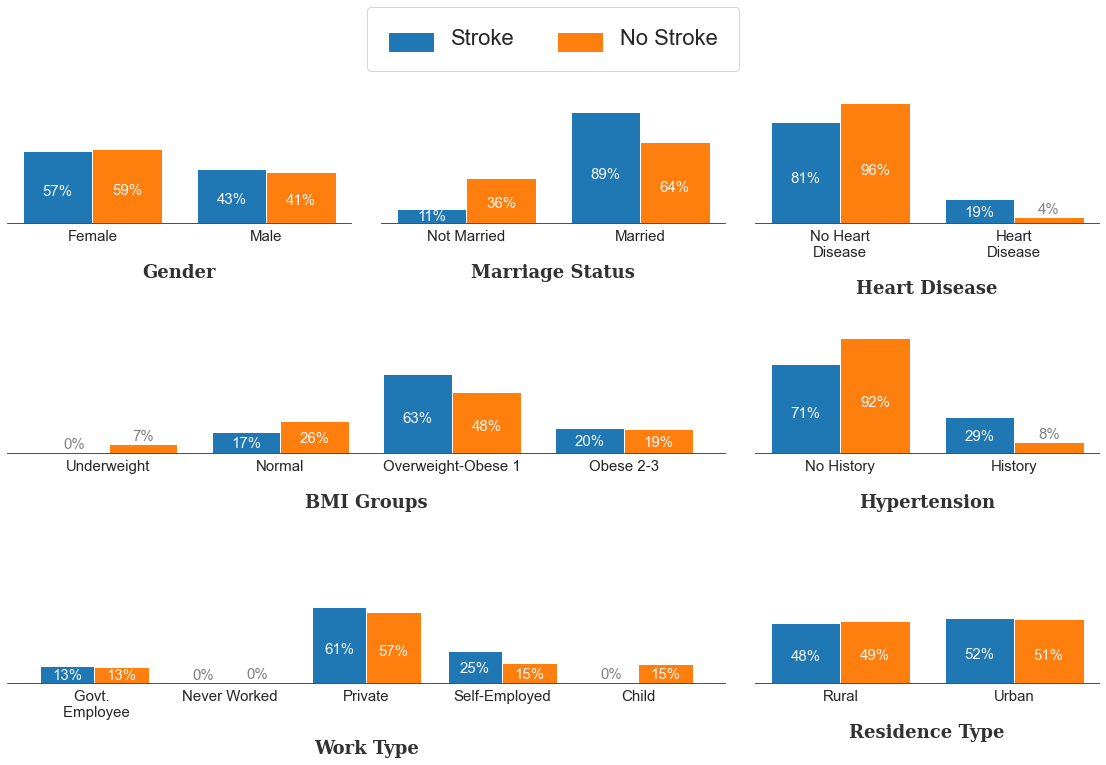

In [48]:
import matplotlib.gridspec as gridspec
fig3 = plt.figure(constrained_layout=False)

gs = fig3.add_gridspec(3,3)
ax1 = fig3.add_subplot(gs[0,0])
ax2 = fig3.add_subplot(gs[0,1])
ax3 = fig3.add_subplot(gs[0,2])
ax4 = fig3.add_subplot(gs[1,2])
ax5 = fig3.add_subplot(gs[1,:2])
ax6 = fig3.add_subplot(gs[2,2])
ax7 = fig3.add_subplot(gs[2,:2])

def getPercent_df(df,category):
    temp_df = pd.DataFrame(df[category].value_counts())
    temp_df["Percentage"] = temp_df[category].apply(lambda x:x/sum(temp_df[category])*100)
    temp_df=temp_df.sort_index(ascending=True)
    return temp_df

def addBarChart(ax,category):
    hadStroke=getPercent_df(str_only,category)
    noStroke=getPercent_df(no_str_only,category)

    if 'work_type' in category:
        add_categories=pd.DataFrame({'work_type':[0],'Percentage':[0]},index=['Never_worked'])
        hadStroke=pd.concat([hadStroke,add_categories]).sort_index()

   # print('\nstroke\n',hadStroke) 
    #print('\nnostroke\n',noStroke)
    x = np.arange(len(hadStroke))
    
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

    ax.bar(x, height=hadStroke["Percentage"], zorder=3, color="tab:blue", width=0.4)
    ax.bar(x+0.4, height=noStroke["Percentage"], zorder=3, color="tab:orange", width=0.4)

    ax.set_xticks(x + 0.4 / 2)

    ax.set_xticklabels(hadStroke.index.tolist())

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
    ax.set_xticklabels(ticks[category], fontsize=15)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    #xlbl = ax.xaxis.get_label().get_text()
   # ax.set_xlabel(xlabels[xlbl],fontsize=19)
   # ax.xaxis.set_label_coords(0.5,4)
    
    ax.set_ylim([0,100])
    length=[i for i in range(0,len(hadStroke.index.tolist()))]
    for i,j in zip(length, hadStroke["Percentage"]):
        if j <=11:
            xy=(i, j+6)
            color='#808080'
        else:
            xy=(i, j/2.30)
            color='#f6f6f6'
        ax.annotate(f'{j:0.0f}%',
                    xy=xy, 
                    color=color, 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 15)
        
    for i,j in zip(length, noStroke["Percentage"]):
        if j <=11:
            xy=(i+0.4, j+6)
            color='#808080'
        else:
            xy=(i+0.4, j/2.30)
            color='#f6f6f6'
        ax.annotate(f'{j:0.00f}%',
                    xy=xy, 
                    color=color, 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 15)
        
    ax.set_xlabel( xlabels[category], fontsize=18, fontweight='bold', fontfamily='serif', color="#323232",labelpad=20)  
    
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='tab:orange', label='No Stroke')
blue_patch = mpatches.Patch(color='tab:blue', label='Stroke')
leg = fig3.legend(loc='upper center',
                 bbox_to_anchor=(.5, 1.10),
                 borderpad=1,
                  prop={'size': 22},
                 handles=[blue_patch,red_patch],
                 ncol=2)

for patch in leg.get_patches():
    patch.set_height(18)
    patch.set_y(-6)
    
addBarChart(ax1,'gender')       
addBarChart(ax2,'ever_married')  
addBarChart(ax3,'heart_disease')  
addBarChart(ax4,'hypertension') 
addBarChart(ax6,'Residence_type') 
addBarChart(ax5,'bmi_group') 
addBarChart(ax7,'work_type')

#fig3.suptitle("Percentage of stroke patients by qualitiative variable",fontsize=26,x=0.5,y=.93)
#fig3.text(1.00, .60,"""Each qualitative variable was split into two groups:\n\n  (1) The percentage of patients who experienced a stroke \n  (2) The percentage of patiets who have not experienced a stroke\n\nExample: Of those who experienced strokes, only 5% had a heart disease.""",fontsize=16)
fig3.set_size_inches(16,10)
fig3.tight_layout(pad=3.0)

# Encode Variables: For binary variables w

In [49]:
def encode(df):
    df_temp = df.copy()
    df_temp.loc[:,'ever_married']=df_temp.loc[:,'ever_married'].replace({'Yes':1,'No':0 })
    cols=['gender','Residence_type','work_type']
    df_temp=pd.concat([df_temp,pd.get_dummies(df_temp[cols + ['bmi_group']].astype(str))],axis=1).drop(columns=cols)
    return df_temp
stroke_df_encoded = encode(stroke_df)
continuous_cols= ['avg_glucose_level','bmi','age']
discrete_cols =[col for col in stroke_df_encoded.columns if col not in continuous_cols]
stroke_df_encoded[continuous_cols] = stroke_df_encoded[['avg_glucose_level','bmi','age']].astype(float)
stroke_df_encoded[discrete_cols] = stroke_df_encoded[discrete_cols].astype(float)

# Modeling

In [50]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [51]:
from imblearn.over_sampling import SMOTE
X  = stroke_df_encoded[[col for col in stroke_df_encoded.columns if col != 'stroke']]
y = stroke_df_encoded['stroke']

smote = SMOTE(random_state=328)
X_resampled, y_resampled = smote.fit_resample(X, y)

strokedf_resampled = pd.DataFrame(X_resampled, columns=X.columns)
strokedf_resampled['stroke'] = y_resampled
strokedf_resampled

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,diabetic,bmi_group,gender_Female,gender_Male,Residence_type_Rural,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,bmi_group_1,bmi_group_2,bmi_group_3,bmi_group_4,stroke
0,9046.000000,67.000000,0.000000,1.0,1.000000,228.690000,36.600000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,1.0
1,31112.000000,80.000000,0.000000,1.0,1.000000,105.920000,32.500000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.0
2,60182.000000,49.000000,0.000000,0.0,1.000000,171.230000,34.400000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.0
3,1665.000000,79.000000,1.000000,0.0,1.000000,174.120000,24.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,1.0
4,56669.000000,81.000000,0.000000,0.0,1.000000,186.210000,29.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,62461.927785,50.718677,0.000000,0.0,1.000000,97.449083,27.665719,0.000000,3.000000,1.000000,0.000000,0.859339,0.140661,0.859339,0.0,0.140661,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.0
9394,62852.664414,77.066672,0.000000,0.0,1.000000,67.084668,24.770574,0.000000,2.032184,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.967816,0.032184,0.000000,1.0
9395,69348.281176,71.677924,0.732208,0.0,0.267792,195.230789,33.848856,0.267792,3.732208,0.267792,0.732208,0.732208,0.267792,0.000000,0.0,0.732208,0.267792,0.0,0.0,0.000000,0.267792,0.732208,1.0
9396,53489.132673,71.544217,0.948008,0.0,1.000000,183.588977,36.130855,0.000000,3.948008,0.948008,0.051992,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.051992,0.948008,1.0


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [53]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=StandardScaler()
stroke_df_scaled=stroke_df_encoded.copy()
#stroke_df_scaled['over70']= stroke_df_scaled['age'].apply(lambda x:1 if x>65  else 0)
stroke_df_scaled['age']=scaler.fit_transform(stroke_df_encoded['age'].values.reshape(-1,1))
stroke_df_scaled['avg_glucose_level']=scaler.fit_transform(stroke_df_encoded['avg_glucose_level'].values.reshape(-1,1))
stroke_df_scaled['bmi']=scaler.fit_transform(stroke_df_encoded['bmi'].values.reshape(-1,1))

x_cols=[col for col in stroke_df_scaled.columns 
        if not any([val in col for val in ('id','stroke')])]
x_train,x_test, y_train, y_test = train_test_split(stroke_df_scaled[x_cols],
                                                   stroke_df_scaled['stroke'],
                                                   test_size=0.3, 
                                                   random_state=328,shuffle = True)

In [88]:
from sklearn.feature_selection import mutual_info_classif,chi2,SelectKBest
def mutualgain(x_train_data,y_train_data,cols_to_remove):
    x_train_data=x_train_data[[col for col in x_train_data.columns 
             if not any([val==col for val in cols_to_remove])]]

    importances=mutual_info_classif(x_train_data,y_train_data,random_state=328)

    feat_importances=pd.Series(importances,x_train_data.columns)
    feat_importances.sort_values
    feat_importances.sort_values().plot(kind='barh')
    plt.axvline(feat_importances.mean(),color='red')
    return feat_importances.sort_values()

def chisquaretest(x_train_data,y_train_data,cols_to_remove):
    x_train_data=x_train_data[[col for col in x_train_data.columns if col not in cols_to_remove]]
    
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(x_train_data,y_train_data)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x_train_data.columns)
    dfpvalues=pd.DataFrame(np.round(fit.pvalues_,4))
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores,dfpvalues],axis=1)
    featureScores.columns = ['Variable','Score','pvals']  #naming the dataframe columns
    scores=featureScores.nlargest(15,'Score')
    print(featureScores.nlargest(15,'Score'))
    return featureScores.sort_values(by='Score',ascending=False)

                   Variable      Score   pvals
1             heart_disease  67.025129  0.0000
0              hypertension  59.352489  0.0000
3                  diabetic  51.242679  0.0000
10       work_type_children  18.664777  0.0000
2              ever_married  12.420532  0.0004
9   work_type_Self-employed  10.688505  0.0011
11              bmi_group_1   7.984121  0.0047
12              bmi_group_2   4.672745  0.0306
13              bmi_group_3   4.243701  0.0394
14              bmi_group_4   0.720523  0.3960
7    work_type_Never_worked   0.560583  0.4540
8         work_type_Private   0.205153  0.6506
5               gender_Male   0.044708  0.8325
4             gender_Female   0.032155  0.8577
6        work_type_Govt_job   0.001234  0.9720


['hypertension',
 'heart_disease',
 'work_type_children',
 'ever_married',
 'age',
 'work_type_Self-employed',
 'diabetic']

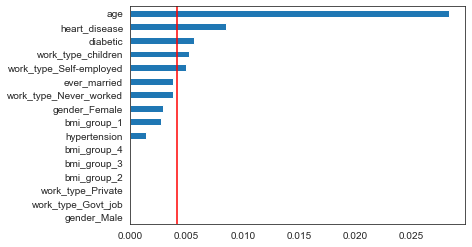

In [108]:
cols_to_remove_fs=('id','stroke','bmi_group','obese_class','bmi','avg_glucose_level')
feat_imp_encoded=mutualgain(x_train,y_train,cols_to_remove_fs)

cols_to_remove_chi=('bmi','avg_glucose_level','age','bmi_group')
chi_scores_encoded=chisquaretest(x_train,y_train,cols_to_remove_chi)

encoded_cols_fs=feat_imp_encoded[feat_imp_encoded>feat_imp_encoded.mean()].index.tolist()
encoded_cols_chi= chi_scores_encoded['Variable'].values.tolist()[0:5]
encoded_cols= list(set(encoded_cols_fs+encoded_cols_chi))
encoded_cols

                  Variable      Score   pvals
1            heart_disease  67.025129  0.0000
0             hypertension  59.352489  0.0000
9       work_type_children  18.664777  0.0000
2             ever_married  12.420532  0.0004
8  work_type_Self-employed  10.688505  0.0011
6   work_type_Never_worked   0.560583  0.4540
7        work_type_Private   0.205153  0.6506
4              gender_Male   0.044708  0.8325
3            gender_Female   0.032155  0.8577
5       work_type_Govt_job   0.001234  0.9720


['hypertension',
 'heart_disease',
 'work_type_children',
 'ever_married',
 'age',
 'work_type_Self-employed']

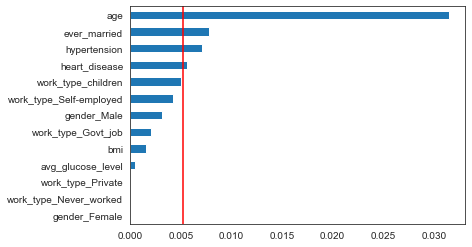

In [103]:
cols_to_remove_fs=('id',
                   'stroke',
                   'obese_class',
                   'bmi_group',
                   'bmi_group_1',
                   'bmi_group_2',
                   'bmi_group_3',
                   'bmi_group_4',
                   'diabetic')

feat_imp_nonencoded=mutualgain(x_train,y_train,cols_to_remove_fs)

cols_to_remove_chi=('bmi',
                    'avg_glucose_level',
                    'age',
                    'bmi_group',
                    'bmi_group_1',
                    'bmi_group_2',
                    'bmi_group_3',
                    'bmi_group_4',
                    'diabetic')

chi_scores_nonencoded=chisquaretest(x_train,y_train,cols_to_remove_chi)

nonencoded_cols_fs=feat_imp_nonencoded[feat_imp_nonencoded>feat_imp_nonencoded.mean()].index.tolist()
nonencoded_cols_chi= chi_scores_nonencoded['Variable'].values.tolist()[:5]
nonencoded_cols= list(set(nonencoded_cols_fs+nonencoded_cols_chi))
nonencoded_cols

In [331]:
def run(logistic,randomforest):
    data=np.array([logistic,randomforest]).T
    data[np.isnan(data)] = 0
    print (logistic)
    index = pd.MultiIndex.from_product([['Overall Accuracy','roc','precision','specificity','recall','f1']],
                                       names=['Metric'])
    columns = pd.MultiIndex.from_product([['Logistic Regression', 'Random Forest']],
                                         names=['Model'])

    model_results = pd.DataFrame(data, index=index, columns=columns)
    return model_results

def encode_vars(df):
    df=df.copy()
    df.loc[:,'ever_married'].replace({'Yes':1,'No':0 },inplace=True)
    cols=['gender','Residence_type','work_type']
    df=pd.concat([df,pd.get_dummies(df[cols])],axis=1).drop(columns=cols)
    return df

def display_metrics(df_models,title):    
    import matplotlib
    colors = ["lightgray","lightgray","#0f4c81"]
    colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    background_color = "#fbfbfb"

    fig = plt.figure(figsize=(10,8)) # create figure
    gs = fig.add_gridspec(4, 2)
    gs.update(wspace=0.1, hspace=0.5)
    ax0 = fig.add_subplot(gs[0, :])

    sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
    fig.patch.set_facecolor(background_color) # figure background color
    ax0.set_facecolor(background_color) 

    ax0.text(0,-0.15,'Model Comparison: {}'.format(title),fontsize=16,fontweight='bold',fontfamily='serif')
    #ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
    ax0.tick_params(axis=u'both', which=u'both',length=0)


    plt.show()

def cm(cm1,cm2,subtitle):
    colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
    colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


    background_color = "#fbfbfb"

    fig = plt.figure(figsize=(12,12)) # create figure
    gs = fig.add_gridspec(3, 2)
    gs.update(wspace=0.05, hspace=0.6)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    ax0.set_facecolor(background_color) # axes background color

    # Overall
    sns.heatmap(cm1, cmap=colormap,annot=True,fmt="d", 
                linewidths=5,
                cbar=False,
                ax=ax0,
                yticklabels=['Actual \nStroke','Actual \n       Non-Stroke'],
                xticklabels=['Predicted Stroke','Predicted Non-Stroke'],annot_kws={"fontsize":12})

    sns.heatmap(cm2, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
                yticklabels=['Actual \nStroke','Actual      \n Non-Stroke'],
                xticklabels=['Predicted Stroke','Predicted Non-Stroke'],
                annot_kws={"fontsize":12,"horizontalalignment":'right','verticalalignment':'center'})



    ax0.tick_params(axis=u'both', which=u'both',length=0)
    background_color = "#fbfbfb"
    fig.patch.set_facecolor(background_color) # figure background color
    ax0.set_facecolor(background_color) 

    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.set_facecolor(background_color) 

    ax0.text(0,-0.50,'Random Forest Performance',fontsize=14,fontweight='bold',fontfamily='serif')
    ax0.text(0,-0.2,subtitle,fontsize=11,fontfamily='serif')

    ax1.text(0,-0.50,'Logistic Regression Performance',fontsize=14,fontweight='bold',fontfamily='serif')
    ax1.text(0,-0.2,subtitle,fontsize=11,fontfamily='serif')

    plt.show()  

def calculateMetrics(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cm=np.rot90(cm,2)#Confusion Matrix
    tp, fn, fp, tn= cm.ravel()
    #print (cm.ravel())
    #print (cm)
    accuracies = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 10)   #K-Fold Validation
    accuracy = accuracy_score(y_test, y_pred)      
    roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
    precision = tp / (tp + fp)  #Precision Score
    specificity =tn / (tn+fp)
    recall = tp / (tp + fn) #Recall Score
    f1 = 2*((precision*recall)/(precision+recall))
    return cm,accuracies,accuracy,roc,precision,specificity,recall,f1

def getMetrics(models,x_data,y_data,split=True,x_test=None,y_test=None):
    if split:
        x_train,x_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.3, random_state=328,shuffle = True)
    else:
        x_train=x_data
        y_train=y_data
    #print (x_data)
    #print(x_train)
    models=models if isinstance(models,list) else list(models)
    metrics={}
    for model in models:
        cm_test,accuracies_test,accuracy_test,roc_test,precision_test,specificity,recall_test,f1_test=calculateMetrics(model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test)
        
        model_metrics= {'Confusion':cm_test,
                        'Cross_fold_accuracies':accuracies_test,
                        'Overall Accuracy':accuracy_test,
                        'roc':roc_test,
                        'precision':precision_test,
                        'specificity': specificity,
                        'recall':recall_test,
                        'f1':f1_test}
        
        model_name=type(model).__name__
        metrics[model_name]=model_metrics
    return metrics

C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


[0.9538357094365241, 0.4996443812233286, 0.0, 0.9992887624466572, 0.0, nan]


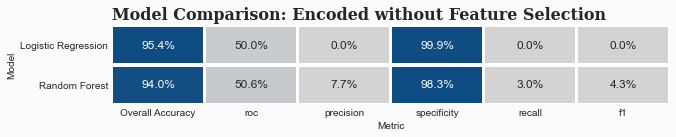

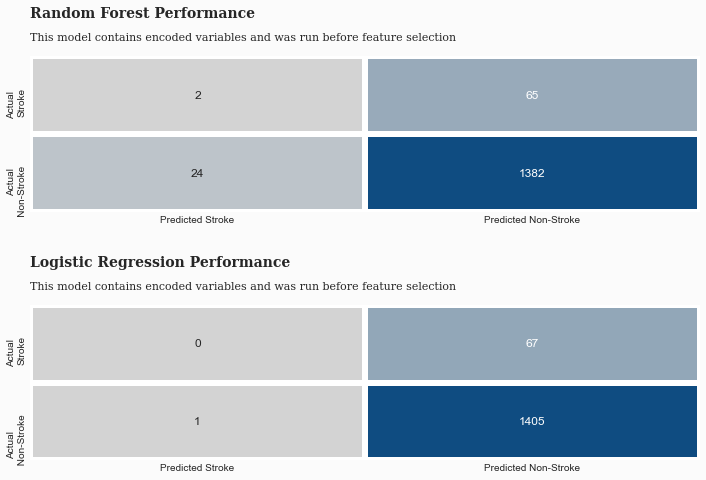

In [327]:
#with feature selection -- encoded
models=[LogisticRegression(random_state=328),
        RandomForestClassifier(random_state=328)]

selected_encoded_data=getMetrics(models,X_scaled2,y)

selected_encoded_logistic=list(selected_encoded_data['LogisticRegression'].values())[2:]
cm_selected_encoded_logistic=selected_encoded_data['LogisticRegression']['Confusion']

selected_encoded_randomforest=list(selected_encoded_data['RandomForestClassifier'].values())[2:]
cm_selected_encoded_rf=selected_encoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_encoded_logistic,selected_encoded_randomforest)
display_metrics(selected_results,'Encoded without Feature Selection')
cm(cm_selected_encoded_rf,cm_selected_encoded_logistic,'This model contains encoded variables and was run before feature selection')

C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars


[0.9545145960624576, 0.5, nan, 1.0, 0.0, nan]


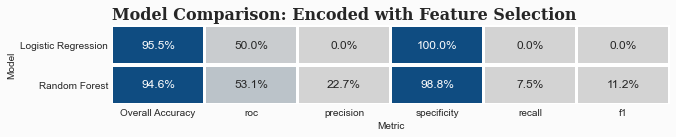

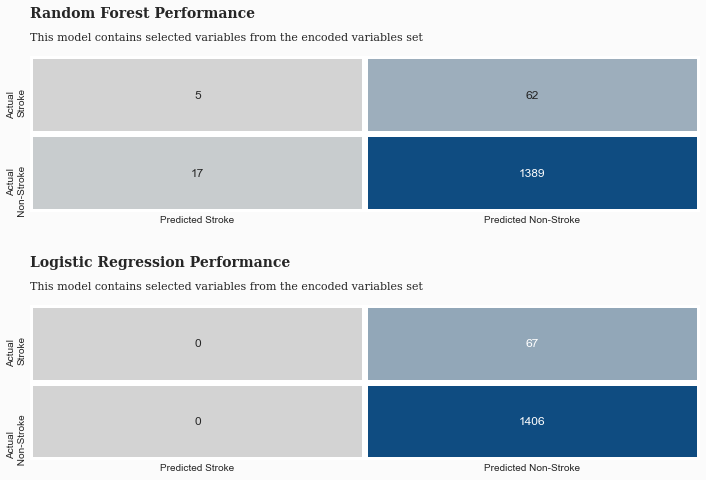

In [336]:
#with feature selection -- encoded
X_encoded=X_scaled2[encoded_cols]
models=[LogisticRegression(random_state=328),
        RandomForestClassifier(random_state=328)]

selected_encoded_data=getMetrics(models,X_encoded,y)

selected_encoded_logistic=list(selected_encoded_data['LogisticRegression'].values())[2:]
cm_selected_encoded_logistic=selected_encoded_data['LogisticRegression']['Confusion']

selected_encoded_randomforest=list(selected_encoded_data['RandomForestClassifier'].values())[2:]
cm_selected_encoded_rf=selected_encoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_encoded_logistic,
                     selected_encoded_randomforest)

display_metrics(selected_results,
                'Encoded with Feature Selection')

cm(cm_selected_encoded_rf,
   cm_selected_encoded_logistic,
   'This model contains selected variables from the encoded variables set')

C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


[0.9538357094365241, 0.4996443812233286, 0.0, 0.9992887624466572, 0.0, nan]


C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


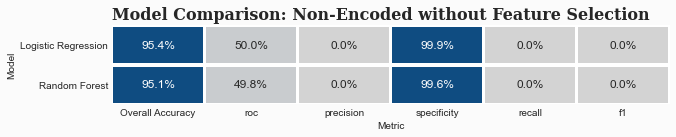

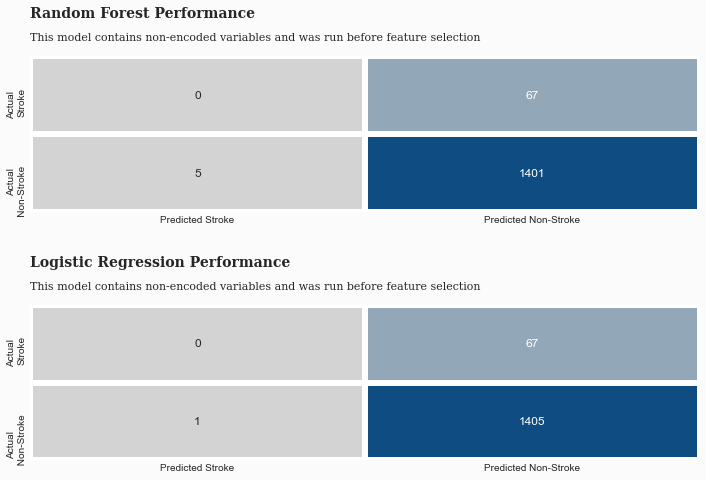

In [285]:
#with feature selection -- encoded
X_nonencoded=X_scaled
models=[LogisticRegression(random_state=328),RandomForestClassifier(random_state=328)]
selected_nonencoded_data=getMetrics(models,X_nonencoded,y)

selected_nonencoded_logistic=list(selected_nonencoded_data['LogisticRegression'].values())[2:]
cm_selected_nonencoded_logistic=selected_nonencoded_data['LogisticRegression']['Confusion']

selected_nonencoded_randomforest=list(selected_nonencoded_data['RandomForestClassifier'].values())[2:]
cm_selected_nonencoded_rf=selected_nonencoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_nonencoded_logistic,
                     selected_nonencoded_randomforest)

display_metrics(selected_results,
                'Non-Encoded without Feature Selection')

cm(cm_selected_nonencoded_rf,
   cm_selected_nonencoded_logistic,
   'This model contains non-encoded variables and was run before feature selection')

C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars


[0.9545145960624576, 0.5, nan, 1.0, 0.0, nan]


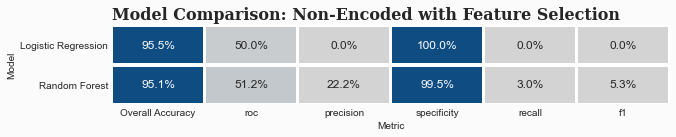

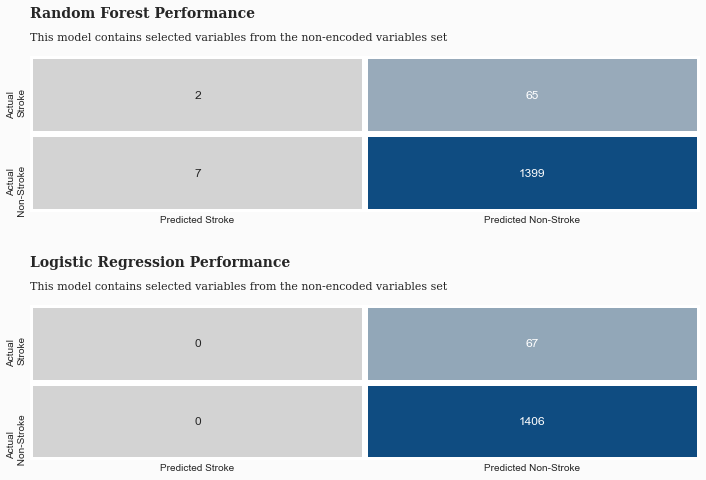

In [295]:
#with feature selection -- encoded
X_nonencoded=X_scaled[nonencoded_cols]
models=[LogisticRegression(random_state=328),RandomForestClassifier(random_state=328)]
selected_nonencoded_data=getMetrics(models,X_nonencoded,y)

selected_nonencoded_logistic=list#with feature selection -- encoded
X_nonencoded=X_scaled[nonencoded_cols]
models=[LogisticRegression(random_state=328),RandomForestClassifier(random_state=328)]
selected_nonencoded_data=getMetrics(models,X_nonencoded,y)

selected_nonencoded_logistic=list(selected_nonencoded_data['LogisticRegression'].values())[2:]
cm_selected_nonencoded_logistic=selected_nonencoded_data['LogisticRegression']['Confusion']

selected_nonencoded_randomforest=list(selected_nonencoded_data['RandomForestClassifier'].values())[2:]
cm_selected_nonencoded_rf=selected_nonencoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_nonencoded_logistic,
                     selected_nonencoded_randomforest)

display_metrics(selected_results,
                'Non-Encoded with Feature Selection')

cm(cm_selected_nonencoded_rf,
   cm_selected_nonencoded_logistic,
   'This model contains selected variables from the non-encoded variables set')

In [376]:
from sklearn.model_selection import validation_curve
x_train,x_test, y_train, y_test = train_test_split(X_encoded,y, test_size=0.2, random_state=328,shuffle = True)

{10: 0.052000000000000005,
 14: 0.081,
 19: 0.081,
 24: 0.081,
 28: 0.081,
 33: 0.081,
 38: 0.081,
 43: 0.081,
 47: 0.081,
 52: 0.081,
 57: 0.081}

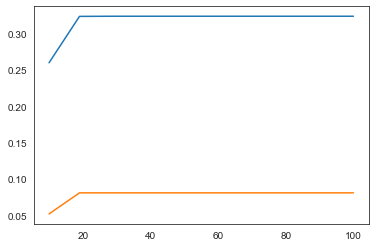

In [401]:
rf= RandomForestClassifier(random_state = 328)
depths=[int(x) for x in np.linspace(10, 100, num = 11)]
train_scoreNum, test_scoreNum=validation_curve(rf,
                                          X_encoded,
                                          y,
                                          param_name="max_depth",
                                          n_jobs=-1,
                                          param_range=depths,
                                          cv=50, 
                                          scoring="recall")
plt.plot(depths,np.mean(train_scoreNum,axis=1))
plt.plot(depths,np.mean(test_scoreNum,axis=1))
dict(zip(n_est,np.mean(test_scoreNum,axis=1)))

{10: 0.076,
 14: 0.086,
 19: 0.08,
 24: 0.075,
 28: 0.081,
 33: 0.076,
 38: 0.071,
 43: 0.071,
 47: 0.071,
 52: 0.076,
 57: 0.076,
 62: 0.076,
 66: 0.081,
 71: 0.081,
 76: 0.076,
 81: 0.081,
 85: 0.081,
 90: 0.081,
 95: 0.081,
 100: 0.081}

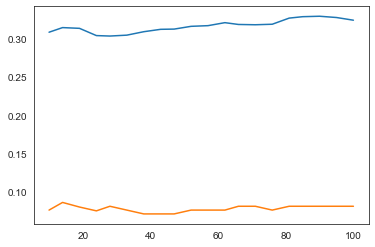

In [396]:
rf= RandomForestClassifier(random_state = 328)
n_est=[int(x) for x in np.linspace(start = 10, stop = 100, num = 20)]
train_scoreNum, test_scoreNum=validation_curve(rf,
                                          X_encoded,
                                          y,
                                          param_name="n_estimators",
                                          n_jobs=-1,
                                          param_range= n_est,
                                          cv=50, 
                                          scoring="recall")
plt.plot(n_est,np.mean(train_scoreNum,axis=1))
plt.plot(n_est,np.mean(test_scoreNum,axis=1))
dict(zip(n_est,np.mean(test_scoreNum,axis=1)))

{0: nan,
 1: nan,
 2: 0.07142857142857142,
 3: 0.062142857142857146,
 4: 0.06690476190476191,
 5: 0.05261904761904762,
 6: 0.03809523809523809,
 7: 0.023809523809523808,
 8: 0.023809523809523808,
 9: 0.0047619047619047615,
 10: 0.009523809523809523,
 11: 0.0047619047619047615,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0}

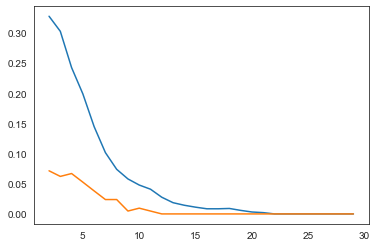

In [398]:
rf= RandomForestClassifier(random_state = 328)
min_samples=[i for i in range(0,30)]
train_scoreNum, test_scoreNum=validation_curve(rf,
                                          X_encoded,
                                          y,
                                          param_name="min_samples_split",
                                          n_jobs=-1,
                                          param_range= min_samples,
                                          cv=10, 
                                          scoring="recall")
plt.plot(min_samples,np.mean(train_scoreNum,axis=1))
plt.plot(min_samples,np.mean(test_scoreNum,axis=1))
dict(zip(min_samples,np.mean(test_scoreNum,axis=1)))

{0: nan,
 1: 0.081,
 2: 0.013000000000000001,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0}

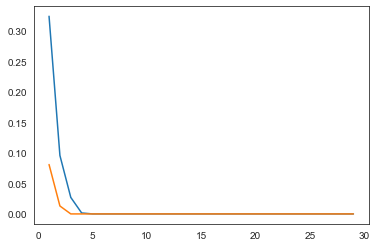

In [399]:
rf= RandomForestClassifier(random_state = 328)
train_scoreNum, test_scoreNum=validation_curve(rf,
                                          X_encoded,
                                          y,
                                          param_name="min_samples_leaf",
                                          n_jobs=-1,
                                          param_range= min_samples,
                                          cv=50, 
                                          scoring="recall")
plt.plot(min_samples,np.mean(train_scoreNum,axis=1))
plt.plot(min_samples,np.mean(test_scoreNum,axis=1))
dict(zip(min_samples,np.mean(test_scoreNum,axis=1)))

{0: nan,
 1: 0.08900000000000001,
 2: 0.081,
 3: 0.066,
 4: 0.066,
 5: 0.07,
 6: 0.07,
 7: 0.075}

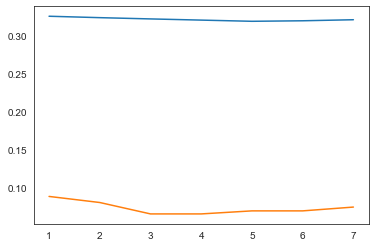

In [400]:
rf= RandomForestClassifier(random_state = 328)
max_feats=[i for i in range(0,X_encoded.shape[1])]
train_scoreNum, test_scoreNum=validation_curve(rf,
                                          X_encoded,
                                          y,
                                          param_name="max_features",
                                          n_jobs=-1,
                                          param_range=max_feats,
                                          cv=50, 
                                          scoring="recall")
plt.plot(max_feats,np.mean(train_scoreNum,axis=1))
plt.plot(max_feats,np.mean(test_scoreNum,axis=1))
dict(zip(max_feats,np.mean(test_scoreNum,axis=1)))

In [317]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
import warnings
import time
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [342]:
def hyperparameter_tune(base_model, parameters, n_iter, kfold, X, y):
    start_time = time.time()
    
    # Arrange data into folds with approx equal proportion of classes within each fold
    k = StratifiedKFold(n_splits=kfold, shuffle=False)
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=328,
                            scoring="recall"
                                      )
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="recall")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model,optimal_model.best_params_, optimal_model.best_score_

In [406]:
scikit.__version__

NameError: name 'scikit' is not defined

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(X_encoded,y, test_size=0.33, random_state=328,shuffle = True)

In [405]:
base_model = RandomForestClassifier(n_jobs=-1,
                                   random_state=328)

lots_of_parameters = {
    "max_depth": [14,15,30, None],
    "n_estimators": [50,90,95,100,105],
    "max_features": [1,"auto",],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    "min_samples_split": [2]
    "min_samples_leaf":[1]
}
    
parameters = {
    "max_depth": [3, 5, 10, None],
    "n_estimators": [100, 200, 300, 400, 500]
}

optimal_model,best_params, best_score = hyperparameter_tune(base_model, lots_of_parameters, 5, 100, x_train, y_train)

Elapsed Time: 00:00:17
Cross Val Mean: 0.025, Cross Val Stdev: 0.130
Best Score: 0.040
Best Parameters: {'n_estimators': 50, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}


C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars


[0.9511201629327902, 0.5, nan, 1.0, 0.0, nan]


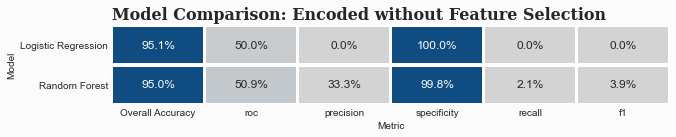

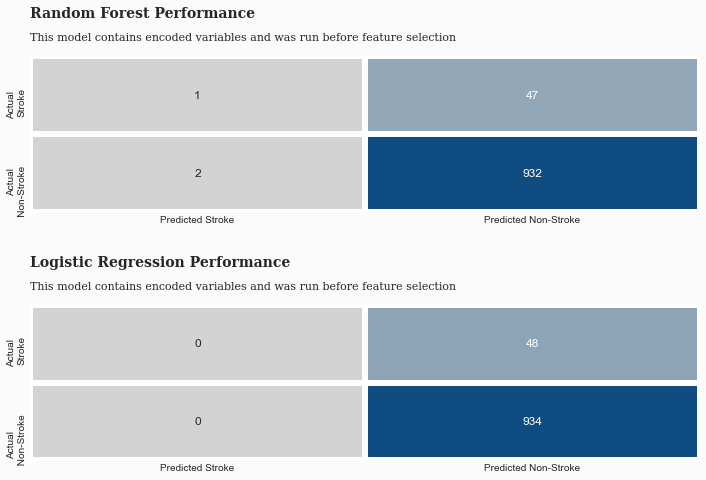

In [404]:
rf_best=RandomForestClassifier(n_jobs=-1, random_state=328, **best_params)

#with feature selection -- encoded
models=[LogisticRegression(random_state=328),
        rf_best]

selected_encoded_data=getMetrics(models,x_train,y_train,x_test=x_test,y_test=y_test,split=False)

selected_encoded_logistic=list(selected_encoded_data['LogisticRegression'].values())[2:]
cm_selected_encoded_logistic=selected_encoded_data['LogisticRegression']['Confusion']

selected_encoded_randomforest=list(selected_encoded_data['RandomForestClassifier'].values())[2:]
cm_selected_encoded_rf=selected_encoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_encoded_logistic,selected_encoded_randomforest)
display_metrics(selected_results,'Encoded without Feature Selection')
cm(cm_selected_encoded_rf,cm_selected_encoded_logistic,'This model contains encoded variables and was run before feature selection')

In [346]:
scores = []
folds = range(2, 8)

for i in folds:
    print("\ncv = ", i)
    opt_model,best_params, best_score = hyperparameter_tune(base_model, parameters, 10, i, x_train, y_train)
    scores.append(best_score)


cv =  2
Elapsed Time: 00:00:01
Cross Val Mean: 0.068, Cross Val Stdev: 0.006
Best Score: 0.068
Best Parameters: {'n_estimators': 200, 'max_depth': None}

cv =  3
Elapsed Time: 00:00:02
Cross Val Mean: 0.056, Cross Val Stdev: 0.015
Best Score: 0.056
Best Parameters: {'n_estimators': 200, 'max_depth': 10}

cv =  4
Elapsed Time: 00:00:03
Cross Val Mean: 0.050, Cross Val Stdev: 0.031
Best Score: 0.050
Best Parameters: {'n_estimators': 200, 'max_depth': None}

cv =  5
Elapsed Time: 00:00:04
Cross Val Mean: 0.056, Cross Val Stdev: 0.031
Best Score: 0.062
Best Parameters: {'n_estimators': 200, 'max_depth': 10}

cv =  6
Elapsed Time: 00:00:04
Cross Val Mean: 0.062, Cross Val Stdev: 0.046
Best Score: 0.062
Best Parameters: {'n_estimators': 200, 'max_depth': None}

cv =  7
Elapsed Time: 00:00:06
Cross Val Mean: 0.037, Cross Val Stdev: 0.028
Best Score: 0.037
Best Parameters: {'n_estimators': 200, 'max_depth': None}


C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars


[0.9511201629327902, 0.5, nan, 1.0, 0.0, nan]


C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in longlong_scalars


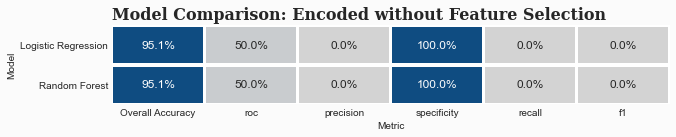

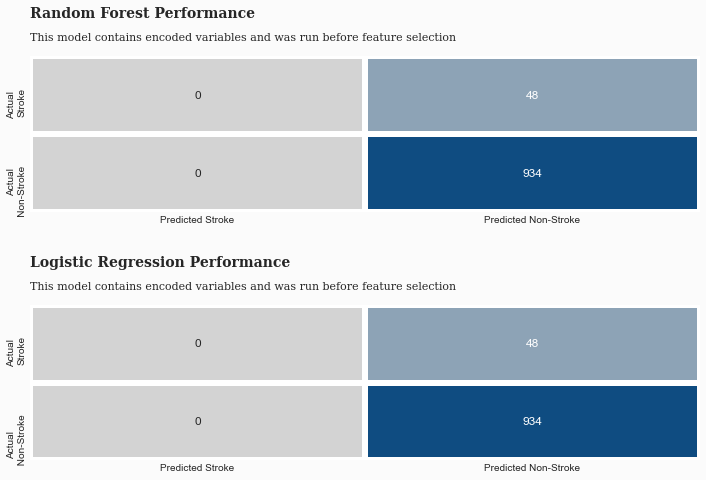

In [332]:
rf_best=RandomForestClassifier(n_jobs=-1, random_state=328, **best_params)

#with feature selection -- encoded
models=[LogisticRegression(random_state=328),
        rf_best]

selected_encoded_data=getMetrics(models,x_train,y_train,x_test=x_test,y_test=y_test,split=False)

selected_encoded_logistic=list(selected_encoded_data['LogisticRegression'].values())[2:]
cm_selected_encoded_logistic=selected_encoded_data['LogisticRegression']['Confusion']

selected_encoded_randomforest=list(selected_encoded_data['RandomForestClassifier'].values())[2:]
cm_selected_encoded_rf=selected_encoded_data['RandomForestClassifier']['Confusion']

selected_results=run(selected_encoded_logistic,selected_encoded_randomforest)
display_metrics(selected_results,'Encoded without Feature Selection')
cm(cm_selected_encoded_rf,cm_selected_encoded_logistic,'This model contains encoded variables and was run before feature selection')

In [300]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1500, num = 20)]
# Number of features to consider at every split
max_features = ['auto',1,2,3,4,5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
X_encoded, y  train_test_split

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
  k = StratifiedKFold(n_splits=kfold, shuffle=False)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 200, 
                               cv = 10, 
                               verbose=2,
                               random_state=328, 
                               n_jobs = -1,
                               scoring='f1')
# Fit the random search model
rf_random.fit(X_encoded, y)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()

rf_random2 = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 150, 
                               cv = 5, 
                               verbose=2,
                               random_state=328, 
                               n_jobs = -1,
                               scoring='recall')
# Fit the random search model
rf_random2.fit(X_nonencoded, y)

In [ ]:
rf_random.best_params_

In [ ]:
C = [x for x in np.linspace(0, 1, num = 200)] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
# Create the random grid

logreg = LogisticRegression()

logreg_random2 = RandomizedSearchCV(estimator = logreg, 
                               param_distributions = log_param_grid, 
                               n_iter = 100, 
                               cv = 10, 
                               verbose=2,
                               random_state=328, 
                               n_jobs = -1,
                               scoring='recall')
logreg_random2.fit(X_nonencoded, y)

# Random Search Parameters with Encoded Variable

In [ ]:
encoded_params_rf=rf_random.best_params_
encoded_params_log=logreg_random.best_params_

In [ ]:
rf_random2.best_params_

In [ ]:
logreg_random2.best_params_

In [ ]:
models2=[LogisticRegression(random_state=328,penalty='l2',C=0.6130653266331658), RandomForestClassifier(random_state=328,
                                                                                     n_estimators= 637,
                                                                                     min_samples_split= 2,
                                                                                     min_samples_leaf= 1,
                                                                                     max_features=4,
                                                                                     max_depth= 90,
                                                                                     bootstrap= False)]
org_data2=getMetrics(models2,X_nonencoded,y)

org_logistic2=list(org_data['LogisticRegression'].values())[2:]
org_randomforest2=list(org_data['RandomForestClassifier'].values())[2:]
data2=np.array([org_logistic,org_randomforest]).T

index = pd.MultiIndex.from_product([['Overall Accuracy','roc','precision','specificity','sensitivity','recall','f1']],
                                   names=['Metric'])
columns = pd.MultiIndex.from_product([['Logistic Regression', 'Random Forest']],
                                     names=['Model'])

model_results = pd.DataFrame(data, index=index, columns=columns)
model_results

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1090, stop = 1140, num = 5)]
# Number of features to consider at every split
max_features = [1,2]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 80, stop = 100, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator = rf, 
                               param_grid = random_grid, 
                               cv = 3, 
                               verbose=2,
                               n_jobs = -1,
                               scoring='recall')
# Fit the random search model
rf_grid.fit(X_encoded, y)

In [ ]:
rf_grid.best_params_

In [ ]:
models=[LogisticRegression(random_state=328,penalty='l2',C=0.16080402010050251), RandomForestClassifier(random_state=328,
                                                                                     n_estimators= 1090,
                                                                                     min_samples_split= 2,
                                                                                     min_samples_leaf= 1,
                                                                                     max_features=1,
                                                                                     max_depth= 80,
                                                                                     bootstrap= True)]
org_data=getMetrics(models,X_encoded,y)

org_logistic=list(org_data['LogisticRegression'].values())[2:]
org_randomforest=list(org_data['RandomForestClassifier'].values())[2:]
data=np.array([org_logistic,org_randomforest]).T

index = pd.MultiIndex.from_product([['Overall Accuracy','roc','precision','specificity','sensitivity','recall','f1']],
                                   names=['Metric'])
columns = pd.MultiIndex.from_product([['Logistic Regression', 'Random Forest']],
                                     names=['Model'])

model_results = pd.DataFrame(data, index=index, columns=columns)
model_results

In [ ]:
{'n_estimators': 637,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 90,
 'bootstrap': False}

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 610, stop = 650, num = 10)]
# Number of features to consider at every split
max_features = [3,4]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 80, stop = 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()

rf_grid2 = GridSearchCV(estimator = rf, 
                               param_grid = random_grid, 
                               cv = 3, 
                               verbose=2,
                               n_jobs = -1,
                               scoring='recall')
# Fit the random search model
rf_grid2.fit(X_encoded, y)

In [ ]:
models=[LogisticRegression(random_state=328,penalty='l2',C=52.26130653266331), RandomForestClassifier(random_state=328,
                                                                                     n_estimators= 11,
                                                                                     min_samples_split= 2,
                                                                                     min_samples_leaf= 1,
                                                                                     max_features=5,
                                                                                     max_depth= 100,
                                                                                     bootstrap= False)]
org_data=getMetrics(models,X_scaled,y)

org_logistic=list(org_data['LogisticRegression'].values())[2:]
org_randomforest=list(org_data['RandomForestClassifier'].values())[2:]
data=np.array([org_logistic,org_randomforest]).T

index = pd.MultiIndex.from_product([['Overall Accuracy','roc','precision','specificity','sensitivity','recall','f1']],
                                   names=['Metric'])
columns = pd.MultiIndex.from_product([['Logistic Regression', 'Random Forest']],
                                     names=['Model'])

model_results = pd.DataFrame(data, index=index, columns=columns)
model_results